# Project: Sign Language Digit Recognition


![img](./sign-language-digits-dataset/Examples/example_0.JPG)
![img](./sign-language-digits-dataset/Examples/example_1.JPG)
![img](./sign-language-digits-dataset/Examples/example_2.JPG)
![img](./sign-language-digits-dataset/Examples/example_3.JPG)
![img](./sign-language-digits-dataset/Examples/example_4.JPG)
![img](./sign-language-digits-dataset/Examples/example_5.JPG)
![img](./sign-language-digits-dataset/Examples/example_6.JPG)
![img](./sign-language-digits-dataset/Examples/example_7.JPG)
![img](./sign-language-digits-dataset/Examples/example_8.JPG)
![img](./sign-language-digits-dataset/Examples/example_9.JPG)


To cap off the practical part of this course you will be designing and training a neural network that can recognize sign language digits. Sign language contains single hand gestures for the digits 0-9, as illustrated above. 

This type of problem is perfectly suited for a CNN. To train this network we have a dataset of about 2000 images available from <https://github.com/ardamavi/Sign-Language-Digits-Dataset> that you can find in the `sign-language-digits-dataset` directory.

For this project you are expected to make a Jupyter notebook that trains a neural network to identify the digits being shown in the images.
You do not need to exceed a certain level of performance but 90% accuracy is easy to achieve with a small CNN. 
I expect you to be able build a CNN that can classify these images and train/test it.
Equally important I expect you to document your solution and report on the outcome.

Outside of doing the minimum 1) load data 2) define model 3) train model, you should do an experiment of your choice.



## Experiment

Choose one of these:

- Vary the width/depth
- Compare different activation functions
- Try data augmentation
- Compare different SGD variants
- Try different loss functions
- Compare different initialization schemes (such as found in [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html))
- Use the full sized color images and compare the difference with the grayscale images
- Can the network recognized rotated images?
- Analyse the evolution of the parameters during training.
- ... come up with your own idea, ask me before you commit to it though.

Report on your findings.

## Grading

The deliverable is just the Jupyter notebook.
I will run the notebook to verify that it works (in the same `mathnn` environment) and read your documentation and comments.
The tutorial notebooks and code snippets below contain most of the code needed to solve this problem so your writing will be important in convicing me that you understand what you are doing.

The project is graded /10 with points given for:

| Item | Points |
|:----------------------------------------------------------------------------------------------------|--------|
| Correctly set up the training process with split dataset, batched SGD, etc.                         |   2.0  |
| Define and train a neural network that can classify the given images                                |   2.0  |
| Document every step you take, <br>others should understand what is happening from the text/comments |   3.0  |
| Describe and perform an experiment of your choice, <br>report your results and draw conclusions     |   3.0  |


## Snippets

Here are some code snippets that could be useful in completing the project.

__<https://pytorch.org/docs/stable/index.html> is your friend!__

### 1. Common imports

In [1]:
 # standard libraries
import math, os, time, glob
import numpy as np

# plotting
import matplotlib.pyplot as plt

# progress bars
from tqdm.notebook import trange, tqdm

# PyTorch
import torch
import torch.nn as nn # lets not write out torch.nn every time
import torch.nn.functional as F # functional versions of the modules in torch.nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### 2. Loading the dataset

The sign-language dataset is contained in the `sign-language-digits-dataset` folder. It consists of a bunch of JPGs organized by which digits is being displayed in them. We could load all these images and collect them together in a tensor and build a corresponding label tensor. But the authors of the dataset have handely provided us with saved numpy arrays that already contain all the images converted to grayscale and downsampled to 64x64, so we can just load those and convert them to PyTorch tensors.

_Remark_: Using grayscale 64x64 images is sufficient to get good results with the benefit of reducing the computational load. If you want to have a go at the 100x100 color images take a look at [torchvision.datasets.ImageFolder](http://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder).

In [2]:
# Load the stored numpy arrays
X = np.load("./sign-language-digits-dataset/X.npy")
Y = np.load("./sign-language-digits-dataset/Y.npy")

# lets inspect their shape
print(f"Shape of X: {X.shape}, shape of Y: {Y.shape}")

# Looks like we have 2062 samples, the images are 64x64 grayscale
# the labels look like they are stored as a probability distribution (a.k.a. one-hot encoding) over the 10 classes:
print(f"Y[0]={Y[0]}, Y[600]={Y[1000]}")

Shape of X: (2062, 64, 64), shape of Y: (2062, 10)
Y[0]=[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Y[600]=[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Having the labels stored as one-hot encodings is not necessarely a problem. However some loss functions (like [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy)) expect the label to be provided as a natural number indicating the class (i.e. 0-9 in our case). Lets convert the one-hot encoding to class indices.

In [3]:
Y = np.argmax(Y, -1)

print(f"Y[0]={Y[0]}, Y[600]={Y[1000]}")

Y[0]=0, Y[600]=4


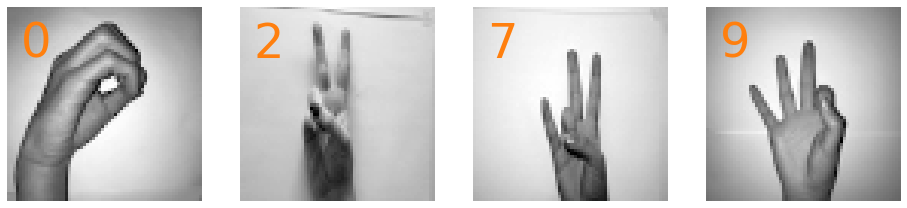

In [4]:
# Lets visualize some of the samples
show = (100, 600, 1500, 2000)
plt.figure(figsize=[4*len(show), 4])

for i in range(len(show)):
    plt.subplot(1, len(show), i+1)
    plt.imshow(X[show[i]], cmap='gray_r')
    plt.text(4, 4, f"{Y[show[i]]}", va='top' ,color='C1', fontsize=48)
    plt.axis("off")
    
plt.show()

Finally lets convert the numpy arrays to PyTorch tensors and load them to the correct device. We also add an empty dimension to the X tensor, check the documentation of [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d) for why we need to do this.

In [5]:
X = torch.tensor(X).unsqueeze(1).to(device)
Y = torch.tensor(Y).to(device)

print(X.shape)
print(Y.shape)

torch.Size([2062, 1, 64, 64])
torch.Size([2062])


### 3. Counting the total number of parameters of a model

In [6]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.ReLU(),
    nn.Conv2d(32, 16, 5)
)

total_params = sum(p.numel() for p in model.parameters())

print(f"The model has {total_params} parameters")

The model has 13648 parameters


In [7]:
# loop throught the Parameter tensors and print the number of elements of each.
for name, p in model.named_parameters():
    print(f"{name} has {p.numel()} parameters")

0.weight has 800 parameters
0.bias has 32 parameters
2.weight has 12800 parameters
2.bias has 16 parameters


### 4. Flattening

At some point when classifying an image with an CNN you will want to transition to a fully connected one. You can do this by simply throwing the channel and spacial dimensions together using a [torch.nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten) module,

In [8]:
network = nn.Flatten()

B = 4 # batchsize
C = 8 # channels
H = 10 # height
W = 10 # width

x = torch.rand(B,C,H,W)
y = network(x)

print(f"Shape of x={x.shape},  shape of y={y.shape}")

Shape of x=torch.Size([4, 8, 10, 10]),  shape of y=torch.Size([4, 800])
